# ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **CHAPTER 7 - ENSEMBLE LEARNING AND RANDOM FORESTS**

---

## **SETUP:**

In [2]:
# %load ../initial_settings.py
"""
Initial settings for data analysis and machine learning.
Use this with: %load ../initial_settings.py
"""

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import sklearn
from packaging import version

import matplotlib as mpl
import matplotlib.pyplot as plt

# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Graphviz source.
os.environ["PATH"] += os.pathsep + "C:/Programy/Graphviz/bin/"

# Default settings for matplotlib.
DARK_BLUE = "#03002e"
LIGHT_GRAY = "#8f8f99"

plt.rc("font", size=14)
plt.rc("legend", fontsize=14)
plt.rc("text", color=DARK_BLUE)

plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelpad=10)
plt.rc("axes", labelcolor=DARK_BLUE)
plt.rc("axes", grid=True)

plt.rc("xtick", labelsize=12, color=DARK_BLUE)
plt.rc("ytick", labelsize=12, color=DARK_BLUE)
plt.rc("xtick.major", pad=10)
plt.rc("ytick.major", pad=10)

plt.rc("grid", color=LIGHT_GRAY)
plt.rc("grid", linestyle="dashed")
plt.rc("grid", linewidth=0.5)
plt.rc("grid", alpha=0.5)

# Create a directory for matplotlib images.
IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)


---

## **VOTING CLASSIFIERS:**

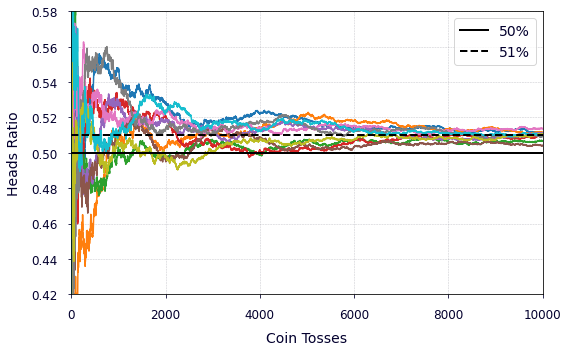

In [3]:
np.random.seed(42)
heads_proba = 0.51
coin_tosses = (np.random.rand(10_000, 10) < heads_proba).astype(np.uint8)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10_001).reshape(-1, 1)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_heads_ratio)
plt.axhline(0.50, 0, 1, linewidth=2, label="50%", linestyle="-", color="black")
plt.axhline(0.51, 0, 1, linewidth=2, label="51%", linestyle="--", color="black")
plt.axis([0, 10_000, 0.42, 0.58])
plt.xlabel("Coin Tosses")
plt.ylabel("Heads Ratio")
plt.legend()

save_fig("law_of_large_numbers")
plt.show()

In [4]:
# Voting classifier.
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier([  # Hard voting by default.
    ("log_reg", LogisticRegression(random_state=42)),
    ("forest_clf", RandomForestClassifier(random_state=42)),
    ("svc_clf", SVC(random_state=42)),
])

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression(random_state=42)),
                             ('forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('svc_clf', SVC(random_state=42))])

In [5]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

log_reg = 0.864
forest_clf = 0.896
svc_clf = 0.896


In [6]:
voting_clf.score(X_test, y_test)

0.912

In [7]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]  # type: ignore

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

In [8]:
# Soft voting.
voting_clf.voting = "soft"
voting_clf.named_estimators["svc_clf"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

---

## **BAGGING AND PASTING:**

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# We have the bagging method by default (bootstrap=True).
# When we want the pasting method, we need to set (bootstrap=False).
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

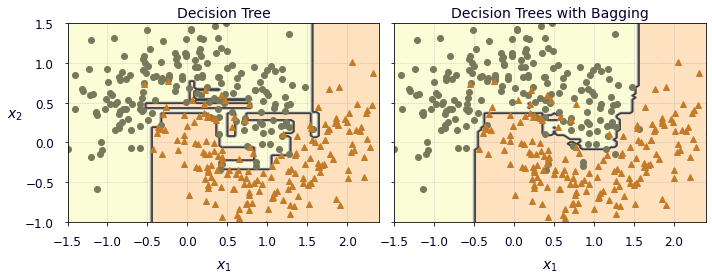

In [39]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes = [-1.5, 2.4, -1.0, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contour(x1, x2, y_pred, alpha=0.75 * alpha, cmap="Greys")
    plt.contourf(x1, x2, y_pred, alpha=0.25 * alpha, cmap="Wistia")
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], c="#78785c", marker="o", linestyle="none")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], c="#c47b27", marker="^", linestyle="none")
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)
    
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")

plt.sca(ax2)
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")

save_fig("decision_tree_without_and_with_bagging")
plt.show()

### **OUT-OF-BAG EVALUATION (OOB):**

In [11]:
# OOB is only available with the bagging method (bootstrap=True).
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [12]:
# Probas for the first 3 instances.
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [13]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of _not_ getting picked. If you draw _m_ instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of _not_ getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

In [14]:
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


---

## **RANDOM FORESTS:**

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [27]:
# A random forest in the cell above is equivalent to a bag of decision trees.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=16, max_features="sqrt"),
    n_estimators=500, random_state=42, max_samples=1.0)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

In [29]:
assert np.all(y_pred_rf == y_pred_bag)

In [30]:
# Random Forests have a extremely useful property: feature importance.
# Let's see this for the Iris dataset.
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)  # type: ignore

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):  # type: ignore
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Petal length and petal width are the most important during classification.

In [34]:
# Feature importance for the MNIST dataset.
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_14044\813415369.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),


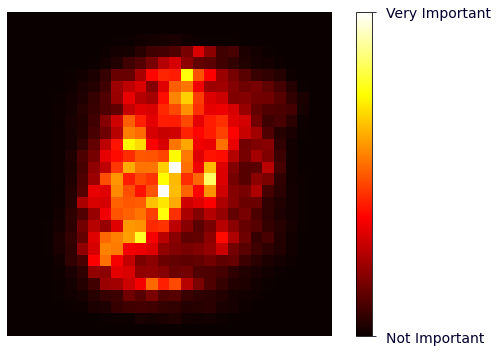

In [35]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X, y)

plt.figure(figsize=(8, 5))
heatmap = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap, cmap="hot")
plt.grid(False)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not Important", "Very Important"], fontsize=14)
plt.axis("off")

save_fig("mnist_feature_importance")
plt.show()

---

## **BOOSTING:**

### **ADABOOST:**

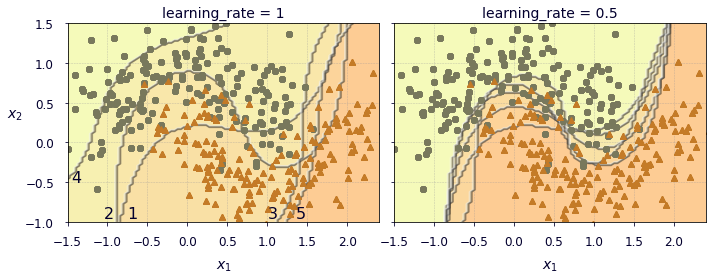

In [43]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

for subplot, learning_rate in ((0, 1), (1, 0.5)):
    plt.sca(axes[subplot])
    
    # AdaBoost algorithm.
    sample_weights = np.ones(m) / m
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)  # type: ignore
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        
        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()
        alpha = learning_rate * np.log((1 - r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum()
        
        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"{learning_rate = }")
    
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting")
plt.show()
        

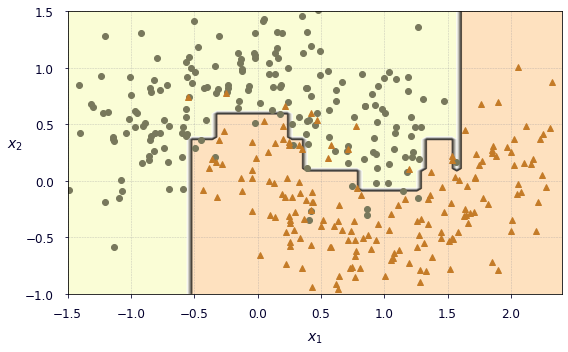

In [45]:
# Obviously there is AdaBoost algorithm in Scikit-Learn.
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30, learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plot_decision_boundary(ada_clf, X_train, y_train)
save_fig("ada_boost")
plt.show()

### **GRADIENT BOOSTING:**

In [66]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [67]:
# Train another Decision Tree on the residual errors made by the previous predictor.
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [68]:
# And another.
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [69]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

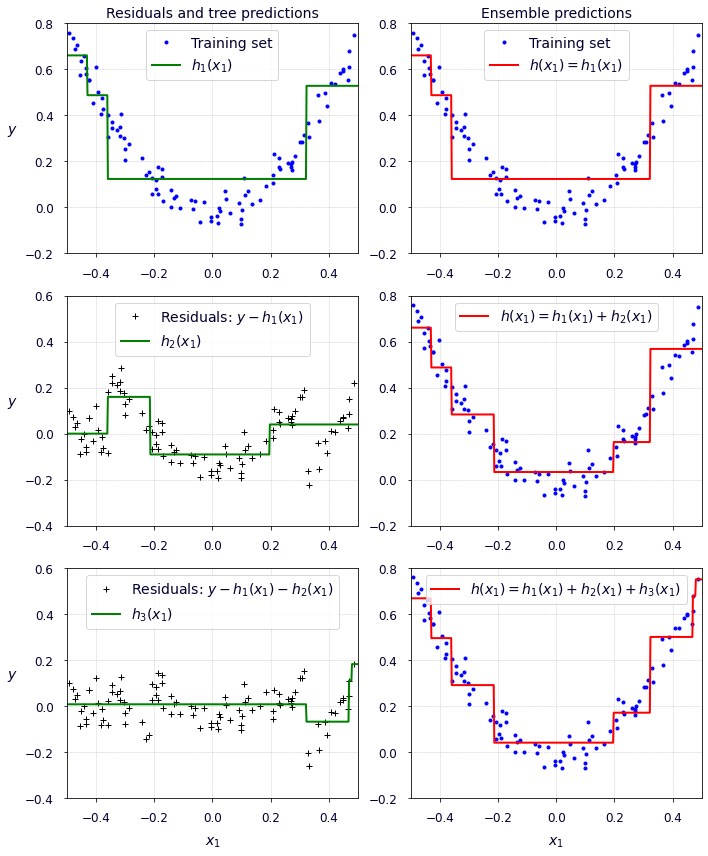

In [73]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting")
plt.show()

In [74]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0,
                                 random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [75]:
gbrt_best = GradientBoostingRegressor(max_depth=2, learning_rate=0.05, n_estimators=500,
                                      n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [76]:
gbrt_best.n_estimators_

92

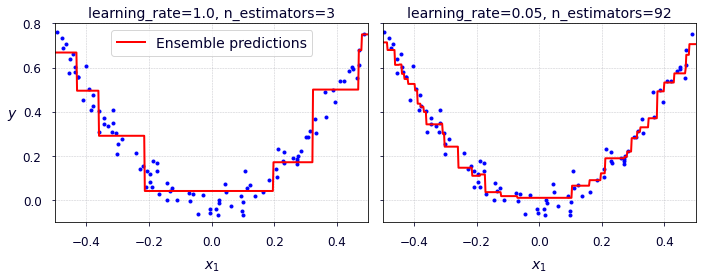

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate")
plt.show()

---

### **STACKING:**

In [81]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier([
    ("lr", LogisticRegression(random_state=42)),
    ("rf", RandomForestClassifier(random_state=42)),
    ("svc", SVC(probability=True, random_state=42)),
], final_estimator=RandomForestClassifier(random_state=43), cv=5)

stacking_clf.fit(X_train, y_train)
stacking_clf.score(X_test, y_test)

0.928